In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import os
import argparse
from pathlib import Path
import re
import random
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Normalization across the whole dataset

In [ ]:
from pathlib import Path
import re, random, math, os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# =========================
# Config
# =========================
SPLIT_DIR = r"/content/drive/MyDrive/CD/patient_data_clean_1800s_nozero_3c"
POS_PATIENTS = {1, 2, 16, 19, 21, 22, 25, 37, 39, 43, 44, 47, 50, 56, 58, 62, 65, 66, 73, 78}

BATCH_SIZE       = 32
EPOCHS           = 100
BASE_LR          = 1e-4
SEED             = 1337
BEST_MODEL_PATH  = "best_keras_img_by_val_auc.h5"

TARGET_H = 1800

# =========================
# Repro
# =========================
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
for g in tf.config.list_physical_devices('GPU'):
    try: tf.config.experimental.set_memory_growth(g, True)
    except Exception: pass

# =========================
# Helpers for ID/labels
# =========================
PATIENT_NUM_RX = re.compile(r'^ID(\d+)')       # e.g., "ID76-2_..." -> 76
BASE_ID_RX     = re.compile(r'^(ID\d+(?:-\d+)?)')

def patient_num_from_path(pathlike):
    stem = Path(pathlike).stem
    m = PATIENT_NUM_RX.match(stem)
    return int(m.group(1)) if m else None

def base_id_from_path(pathlike):
    stem = Path(pathlike).stem
    m = BASE_ID_RX.match(stem)
    return m.group(1) if m else stem

def label_for_file(p: Path) -> int:
    pnum = patient_num_from_path(p)
    return 1 if (pnum is not None and pnum in POS_PATIENTS) else 0

# =========================
# List files & make ID-based splits (80/10/10 by ID)
# =========================
split_dir = Path(SPLIT_DIR)
all_csvs = sorted(split_dir.glob("*.csv"))
if not all_csvs:
    raise FileNotFoundError(f"No CSV found in {SPLIT_DIR}")

# Map: id -> list of files for that patient
id_to_files = {}
for f in all_csvs:
    pid = patient_num_from_path(f)
    if pid is None:
        continue
    id_to_files.setdefault(pid, []).append(f)

all_ids = sorted(id_to_files.keys())
print('all_ids = ', all_ids)

# Stratify by label at ID level
id_labels = np.array([1 if pid in POS_PATIENTS else 0 for pid in all_ids], dtype=int)

ids_trainval, ids_test = train_test_split(
    all_ids, test_size=0.10, random_state=SEED, stratify=id_labels
)
labels_trainval = np.array([1 if pid in POS_PATIENTS else 0 for pid in ids_trainval], dtype=int)

ids_train, ids_val = train_test_split(
    ids_trainval, test_size=0.1111111, random_state=SEED, stratify=labels_trainval
)

train_files = [f for pid in ids_train for f in id_to_files[pid]]
val_files   = [f for pid in ids_val   for f in id_to_files[pid]]
test_files  = [f for pid in ids_test  for f in id_to_files[pid]]

def split_summary_by_ids(name, ids, files):
    ys = np.array([label_for_file(f) for f in files], dtype=int)
    print(f"{name:>6} | ids: {len(ids):4d} | files: {len(files):5d} | pos files: {(ys==1).sum():4d} | neg files: {(ys==0).sum():4d}")

print("\n--- ID-based split summary ---")
split_summary_by_ids("train", ids_train, train_files)
split_summary_by_ids("val",   ids_val,   val_files)
split_summary_by_ids("test",  ids_test,  test_files)
print("------------------------------\n")

# =========================
# Image loader (drop Time; keep ALL other columns) — NO NORMALIZATION
# =========================

def _drop_time_cols(df: pd.DataFrame) -> pd.DataFrame:
    time_like = [c for c in df.columns if isinstance(c, str) and c.strip().lower() == "time"]
    return df.drop(columns=time_like, errors="ignore")

def _to_numeric_df(df: pd.DataFrame) -> pd.DataFrame:
    df = _drop_time_cols(df)
    return df.apply(pd.to_numeric, errors="coerce").fillna(0.0)

def _pad_crop_2d(x: np.ndarray, H: int, W: int) -> np.ndarray:
    h, w = x.shape
    if h < H:
        pad = np.zeros((H, w), dtype=x.dtype); pad[:h, :] = x; x = pad; h = H
    elif h > H:
        x = x[:H, :]; h = H
    if w < W:
        pad = np.zeros((h, W), dtype=x.dtype); pad[:, :w] = x; x = pad
    elif w > W:
        x = x[:, :W]
    return x

def _infer_target_width(example_csv: Path) -> int:
    df = pd.read_csv(example_csv)
    df2 = _to_numeric_df(df)
    return df2.shape[1]

if not len(train_files):
    raise RuntimeError("Empty training split after ID-based split; check your data/IDs.")
TARGET_W = _infer_target_width(train_files[0])
print(f"TARGET_H={TARGET_H}, TARGET_W={TARGET_W}")


def load_csv_as_image_raw(csv_path: Path) -> np.ndarray:
    df = pd.read_csv(csv_path)
    df2 = _to_numeric_df(df)
    mat = df2.to_numpy(dtype=np.float32)
    mat = _pad_crop_2d(mat, TARGET_H, TARGET_W)
    img = mat[:, :, None]
    return img.astype(np.float32)

# tiny raw cache
CACHE_RAW = {}

def load_csv_as_image_raw_cached(csv_path: Path) -> np.ndarray:
    key = ("raw", str(csv_path))
    if key in CACHE_RAW:
        return CACHE_RAW[key]
    img = load_csv_as_image_raw(csv_path)
    CACHE_RAW[key] = img
    return img

# =========================
# Keras Sequence (NO NORMALIZATION)
# =========================
class ImageSequence(keras.utils.Sequence):
    def __init__(self, files, batch_size=BATCH_SIZE, shuffle=True):
        super().__init__()
        self.files = list(files)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.files) / self.batch_size)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.files))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        idxs = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_files = [self.files[i] for i in idxs]
        X_list, y_list = [], []
        for f in batch_files:
            x = load_csv_as_image_raw_cached(f)  # [H,W,1]
            X_list.append(x)
            y_list.append(label_for_file(f))
        return np.stack(X_list, 0), np.array(y_list, dtype=np.int32)

# =========================
# DenseNet-style 2D CNN (binary head)
# =========================

def build_model(h=TARGET_H, w=TARGET_W, c=1, lr=BASE_LR,
                growth_rate=8, block_layers=(4, 6, 6, 6),
                compression=0.5, dropout=0.2):

    inputs = keras.Input(shape=(h, w, c))

    def bn_relu_conv(x, filters, ksize, stride=1):
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, ksize, strides=stride, padding="same", use_bias=False)(x)
        return x

    def dense_layer(x):
        y = bn_relu_conv(x, 4 * growth_rate, 1)
        y = bn_relu_conv(y, growth_rate, 3)
        return layers.Concatenate()([x, y])

    def dense_block(x, L):
        for _ in range(L):
            x = dense_layer(x)
        return x

    def transition_layer(x):
        filters = max(8, int(int(x.shape[-1]) * compression))
        x = bn_relu_conv(x, filters, 1)
        return layers.AveragePooling2D(pool_size=(2, 2), strides=2, padding="same")(x)

    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(inputs)
    x = layers.ReLU()(x)

    for i, L in enumerate(block_layers):
        x = dense_block(x, L)
        if i != len(block_layers) - 1:
            x = transition_layer(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[keras.metrics.BinaryAccuracy(name="acc"), keras.metrics.AUC(name="auc")],
    )
    return model

# =========================
# Data generators
# =========================
train_gen = ImageSequence(train_files, batch_size=BATCH_SIZE, shuffle=True)
val_gen   = ImageSequence(val_files,   batch_size=BATCH_SIZE, shuffle=False)

# Optional: print which columns are being used (from one file)
try:
    tmp_df = pd.read_csv(train_files[0])
    used_cols = [c for c in tmp_df.columns if not (isinstance(c, str) and c.strip().lower()=="time")]
    print("Using columns (excluding Time):", used_cols)
except Exception as _e:
    pass

# =========================
# Train (save BEST by validation loss for parity with your earlier runs)
# =========================
model = build_model()
ckpt = keras.callbacks.ModelCheckpoint(
    BEST_MODEL_PATH, monitor="val_loss", mode="min", save_best_only=True, verbose=1
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[ckpt],
    verbose=1,
)

# =========================
# LOAD the BEST model and TEST (held-out IDs)
# =========================
best_model = keras.models.load_model(BEST_MODEL_PATH)

X_test = np.stack([load_csv_as_image_raw_cached(f) for f in test_files], axis=0)
y_true = np.array([label_for_file(f) for f in test_files], dtype=int)

probs1 = best_model.predict(X_test, verbose=0).ravel().astype(float)
y_pred = (probs1 >= 0.5).astype(int)

try:
    auc = roc_auc_score(y_true, probs1)
except ValueError:
    auc = float('nan')
acc = accuracy_score(y_true, y_pred)
print(f"\nEVALUATED MODEL: {BEST_MODEL_PATH} (selected by best VAL loss)")
print(f"Image shape used: H={TARGET_H}, W={TARGET_W}, C=1")
print(f"Test acc {acc:.3f}, AUC {auc:.3f}")
print("\nConfusion matrix (test):\n", confusion_matrix(y_true, y_pred))
print("\nClassification report (test):\n", classification_report(y_true, y_pred, digits=3))

all_ids =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 33, 34, 35, 36, 37, 38, 39, 43, 44, 45, 47, 49, 50, 51, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 71, 72, 76, 78]

--- ID-based split summary ---
 train | ids:   48 | files:  3090 | pos files: 1117 | neg files: 1973
   val | ids:    6 | files:   339 | pos files:   98 | neg files:  241
  test | ids:    6 | files:   301 | pos files:  151 | neg files:  150
------------------------------

TARGET_H=1800, TARGET_W=3
Using columns (excluding Time): ['Delta total FFT, 1 - 4 Hz, All 1020 No FP', 'Theta total FFT, 4 - 8 Hz, All 1020 No FP', 'Alpha total FFT, 8 - 13 Hz, All 1020 No FP']
Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - acc: 0.6319 - auc: 0.4577 - loss: 0.6856
Epoch 1: val_loss improved from inf to 0.62805, saving model to best_keras_img_by_val_auc.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 283ms/step - acc: 0.6319 - auc: 0.4578 - loss: 0.6855 - val_acc: 0.7109 - val_auc: 0.7483 - val_loss: 0.6281
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.6359 - auc: 0.4827 - loss: 0.6781
Epoch 2: val_loss did not improve from 0.62805
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - acc: 0.6359 - auc: 0.4828 - loss: 0.6781 - val_acc: 0.7109 - val_auc: 0.6964 - val_loss: 0.6301
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.6498 - auc: 0.5310 - loss: 0.6709
Epoch 3: val_loss improved from 0.62805 to 0.60119, saving model to best_keras_img_by_val_auc.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - acc: 0.6498 - auc: 0.5310 - loss: 0.6710 - val_acc: 0.7109 - val_auc: 0.7349 - val_loss: 0.6012
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.6372 - auc: 0.5031 - loss: 0.6671
Epoch 4: val_loss improved from 0.60119 to 0.58332, saving model to best_keras_img_by_val_auc.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - acc: 0.6372 - auc: 0.5032 - loss: 0.6671 - val_acc: 0.7109 - val_auc: 0.7714 - val_loss: 0.5833
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.6384 - auc: 0.4622 - loss: 0.6741
Epoch 5: val_loss did not improve from 0.58332
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - acc: 0.6384 - auc: 0.4626 - loss: 0.6740 - val_acc: 0.7109 - val_auc: 0.7058 - val_loss: 0.6225
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.6460 - auc: 0.5383 - loss: 0.6591
Epoch 6: val_loss did not improve from 0.58332
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - acc: 0.6460 - auc: 0.5385 - loss: 0.6592 - val_acc: 0.7109 - val_auc: 0.6539 - val_loss: 0.6270
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.6358 - auc: 0.5786 - loss: 0.6591
Epoch 7: val_loss did not improve from 0.58332
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - acc: 0.6360 - auc: 0.5786 - loss: 0.6591 - val_acc: 0.7109 - val_auc: 0.6158 - val_loss: 0.6260
Epoch 8/100
97/97 ━━━━

97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - acc: 0.6338 - auc: 0.6126 - loss: 0.6471 - val_acc: 0.7109 - val_auc: 0.7438 - val_loss: 0.5729
Epoch 16/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.6250 - auc: 0.5177 - loss: 0.6756
Epoch 16: val_loss did not improve from 0.57294
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - acc: 0.6252 - auc: 0.5179 - loss: 0.6754 - val_acc: 0.7109 - val_auc: 0.4201 - val_loss: 0.6333
Epoch 17/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.6457 - auc: 0.6312 - loss: 0.6368
Epoch 17: val_loss did not improve from 0.57294
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - acc: 0.6456 - auc: 0.6312 - loss: 0.6368 - val_acc: 0.6726 - val_auc: 0.3567 - val_loss: 0.6556
Epoch 18/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.6396 - auc: 0.6319 - loss: 0.6370
Epoch 18: val_loss did not improve from 0.57294
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - acc: 0.6398 - auc: 0.6318 - loss: 0.6370 - val_acc: 0.6637 - val_auc: 0.3504 - val_loss: 0.6557
Epoch 19/100
97/


EVALUATED MODEL: best_keras_img_by_val_auc.h5 (selected by best VAL loss)
Image shape used: H=1800, W=3, C=1
Test acc 0.498, AUC 0.669

Confusion matrix (test):
 [[150   0]
 [151   0]]

Classification report (test):
               precision    recall  f1-score   support

           0      0.498     1.000     0.665       150
           1      0.000     0.000     0.000       151

    accuracy                          0.498       301
   macro avg      0.249     0.500     0.333       301
weighted avg      0.248     0.498     0.331       301



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


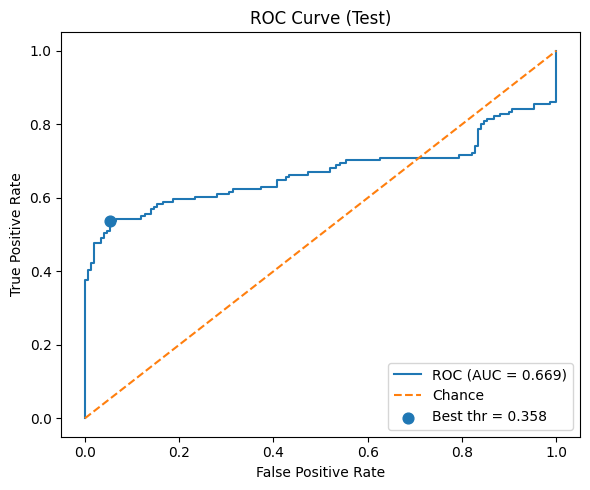

Best threshold (Youden's J): 0.358276
Confusion matrix (rows=true, cols=pred):
[[142   8]
 [ 70  81]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# y_true: (N,) in {0,1}
# probs1: (N,) predicted probabilities for the positive class

def plot_auc_and_confmat(y_true, probs1, save_path="roc_curve.png", show=True):
    # ROC + AUC
    fpr, tpr, thresholds = roc_curve(y_true, probs1)
    auc = roc_auc_score(y_true, probs1)

    # Best threshold by Youden's J (tpr - fpr)
    youden = tpr - fpr
    best_idx = int(np.argmax(youden))
    best_thr = float(thresholds[best_idx])

    # Plot ROC with best-threshold marker
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Chance")
    plt.scatter(fpr[best_idx], tpr[best_idx], s=60, label=f"Best thr = {best_thr:.3f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Test)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(save_path, dpi=200, bbox_inches="tight")
    if show:
        plt.show()

    # Confusion matrix at best threshold
    y_pred = (probs1 >= best_thr).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # Print results
    print(f"Best threshold (Youden's J): {best_thr:.6f}")
    print("Confusion matrix (rows=true, cols=pred):")
    print(cm)

    return best_thr, auc, cm

# ---- run it ----
best_thr, auc_val, cm = plot_auc_and_confmat(y_true, probs1, save_path="roc_curve_test.png", show=True)
